In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, metrics

# COSC 757 Assignment 1
Working with the Algerian Forest Fires Dataset: https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++


In [3]:
#Split CSV into two datasets based on region
bejaia_df = pd.read_csv("bejaia_fire.csv",skiprows=1)
sidibel_df = pd.read_csv("sidibel_fire.csv",skiprows=1)

#Merge them into one dataset with an additional region column
bejaia_df['Region'] = 'Bejaia'
sidibel_df['Region'] = 'Sidi-Bel Abbes'

fire_df = pd.concat([bejaia_df,sidibel_df],ignore_index=True)
fire_df.columns = fire_df.columns.str.strip()
fire_df['Classes'] = fire_df['Classes'].str.strip()
fire_df = fire_df.astype({'DC':'float64','FWI':'float64','Classes':'category','Region':'category'})

## Exploratory Data Analysis

In [4]:
fire_df.columns
#fire_df.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [5]:
fire_df['Classes'].unique()


['not fire', 'fire']
Categories (2, object): ['fire', 'not fire']

No handles with labels found to put in legend.


         Column         Mean   Median Standard Deviation   Min    Max
0           day    15.754098    16.00           8.806957     1     31
1         month     7.500000     7.50           1.110678     6      9
2          year  2012.000000  2012.00           0.000000  2012   2012
3   Temperature    32.172131    32.00           3.626389    22     42
4            RH    61.938525    63.00          14.853668    21     90
5            Ws    15.504098    15.00           2.804414     6     29
6          Rain     0.760656     0.00           1.995304   0.0   16.8
7          FFMC    77.887705    83.50          14.308160  28.6   96.0
8           DMC    14.673361    11.30          12.342668   0.7   65.9
9            DC    49.288115    33.10          47.521981   6.9  220.4
10          ISI     4.759836     3.50           4.146105   0.0   19.0
11          BUI    16.673361    12.45          14.172517   1.1   68.0
12          FWI     7.049180     4.45           7.413128   0.0   31.1


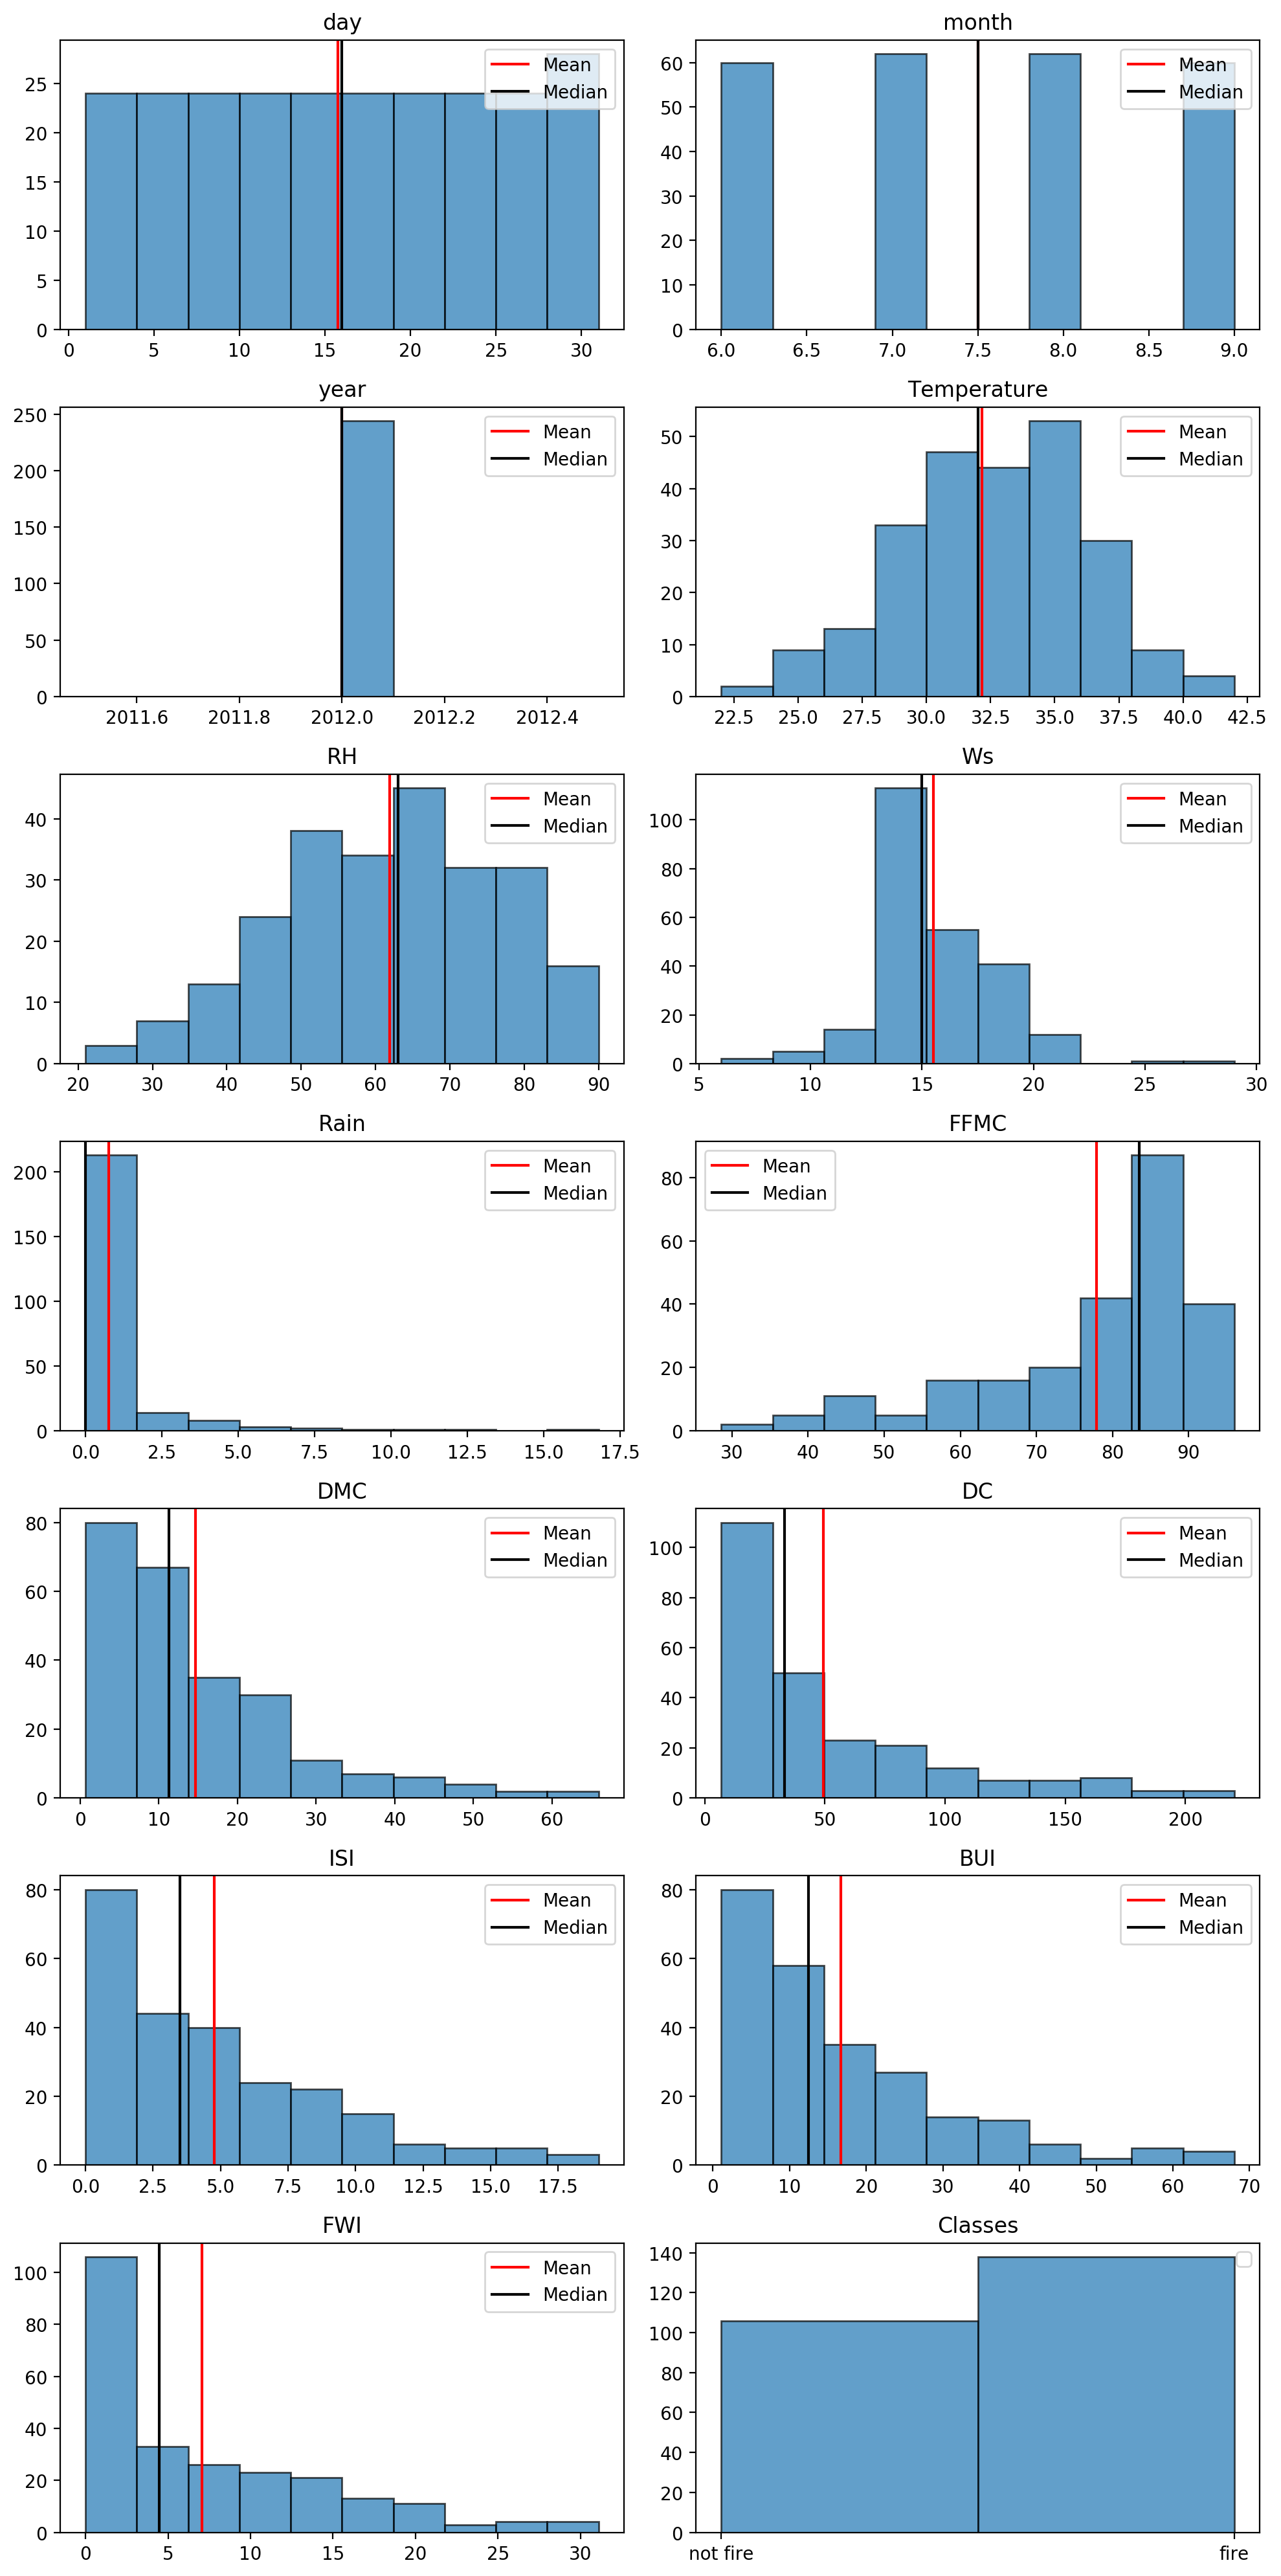

In [296]:
cols = np.array(fire_df.columns)
count=0

col_df = pd.DataFrame(columns=[['Column','Mean','Median', 'Standard Deviation', 'Min', 'Max']])

fig, ax = plt.subplots(7,2,figsize=(10,20),dpi=200)
for i,col in enumerate(ax):
    for j, row in enumerate(col):
        try:
            feature = fire_df[cols[count]]
            feature_arr = np.array(feature)
            #print(cols[count],np.mean(feature_arr))
            if (feature.dtype=='int64') or (feature.dtype=='float64'):
                col_df.loc[len(col_df.index)] = [cols[count], np.mean(feature_arr),np.median(feature_arr),np.std(feature_arr),min(feature_arr),max(feature_arr)]
            ax[i,j].set_title(cols[count])
            if feature.dtype.name == 'category':
                ax[i,j].hist(feature_arr,bins=len(feature.unique()),ec='k',alpha=0.7)
                
            else:
                ax[i,j].hist(feature_arr,ec='k',alpha=0.7)
                ax[i,j].axvline(np.mean(feature_arr),label='Mean',color='r')
                ax[i,j].axvline(np.median(feature_arr),label='Median',color='k')
            ax[i,j].legend()
            count+=1
        except IndexError:
            pass

plt.tight_layout()
plt.savefig("feature_stats.png")
print(col_df)


In [19]:
col_df

,Column,Mean,Median,Standard Deviation,Min,Max
0,day,15.754098,16.00,8.806957,1,31
1,month,7.500000,7.50,1.110678,6,9
2,year,2012.000000,2012.00,0.000000,2012,2012
3,Temperature,32.172131,32.00,3.626389,22,42
4,RH,61.938525,63.00,14.853668,21,90
5,Ws,15.504098,15.00,2.804414,6,29
6,Rain,0.760656,0.00,1.995304,0.0,16.8
7,FFMC,77.887705,83.50,14.308160,28.6,96.0
8,DMC,14.673361,11.30,12.342668,0.7,65.9
9,DC,49.288115,33.10,47.521981,6.9,220.4


### Fire Classification Feature Relationships

In [34]:
# Explore Fire Classification vs Variables

#Turn Fire Classification into a Flag Variable
fire_int = []
for fireclass in fire_df['Classes']:
    if fireclass == "not fire":
        fire_int.append(0)
    elif fireclass == "fire":
        fire_int.append(1)





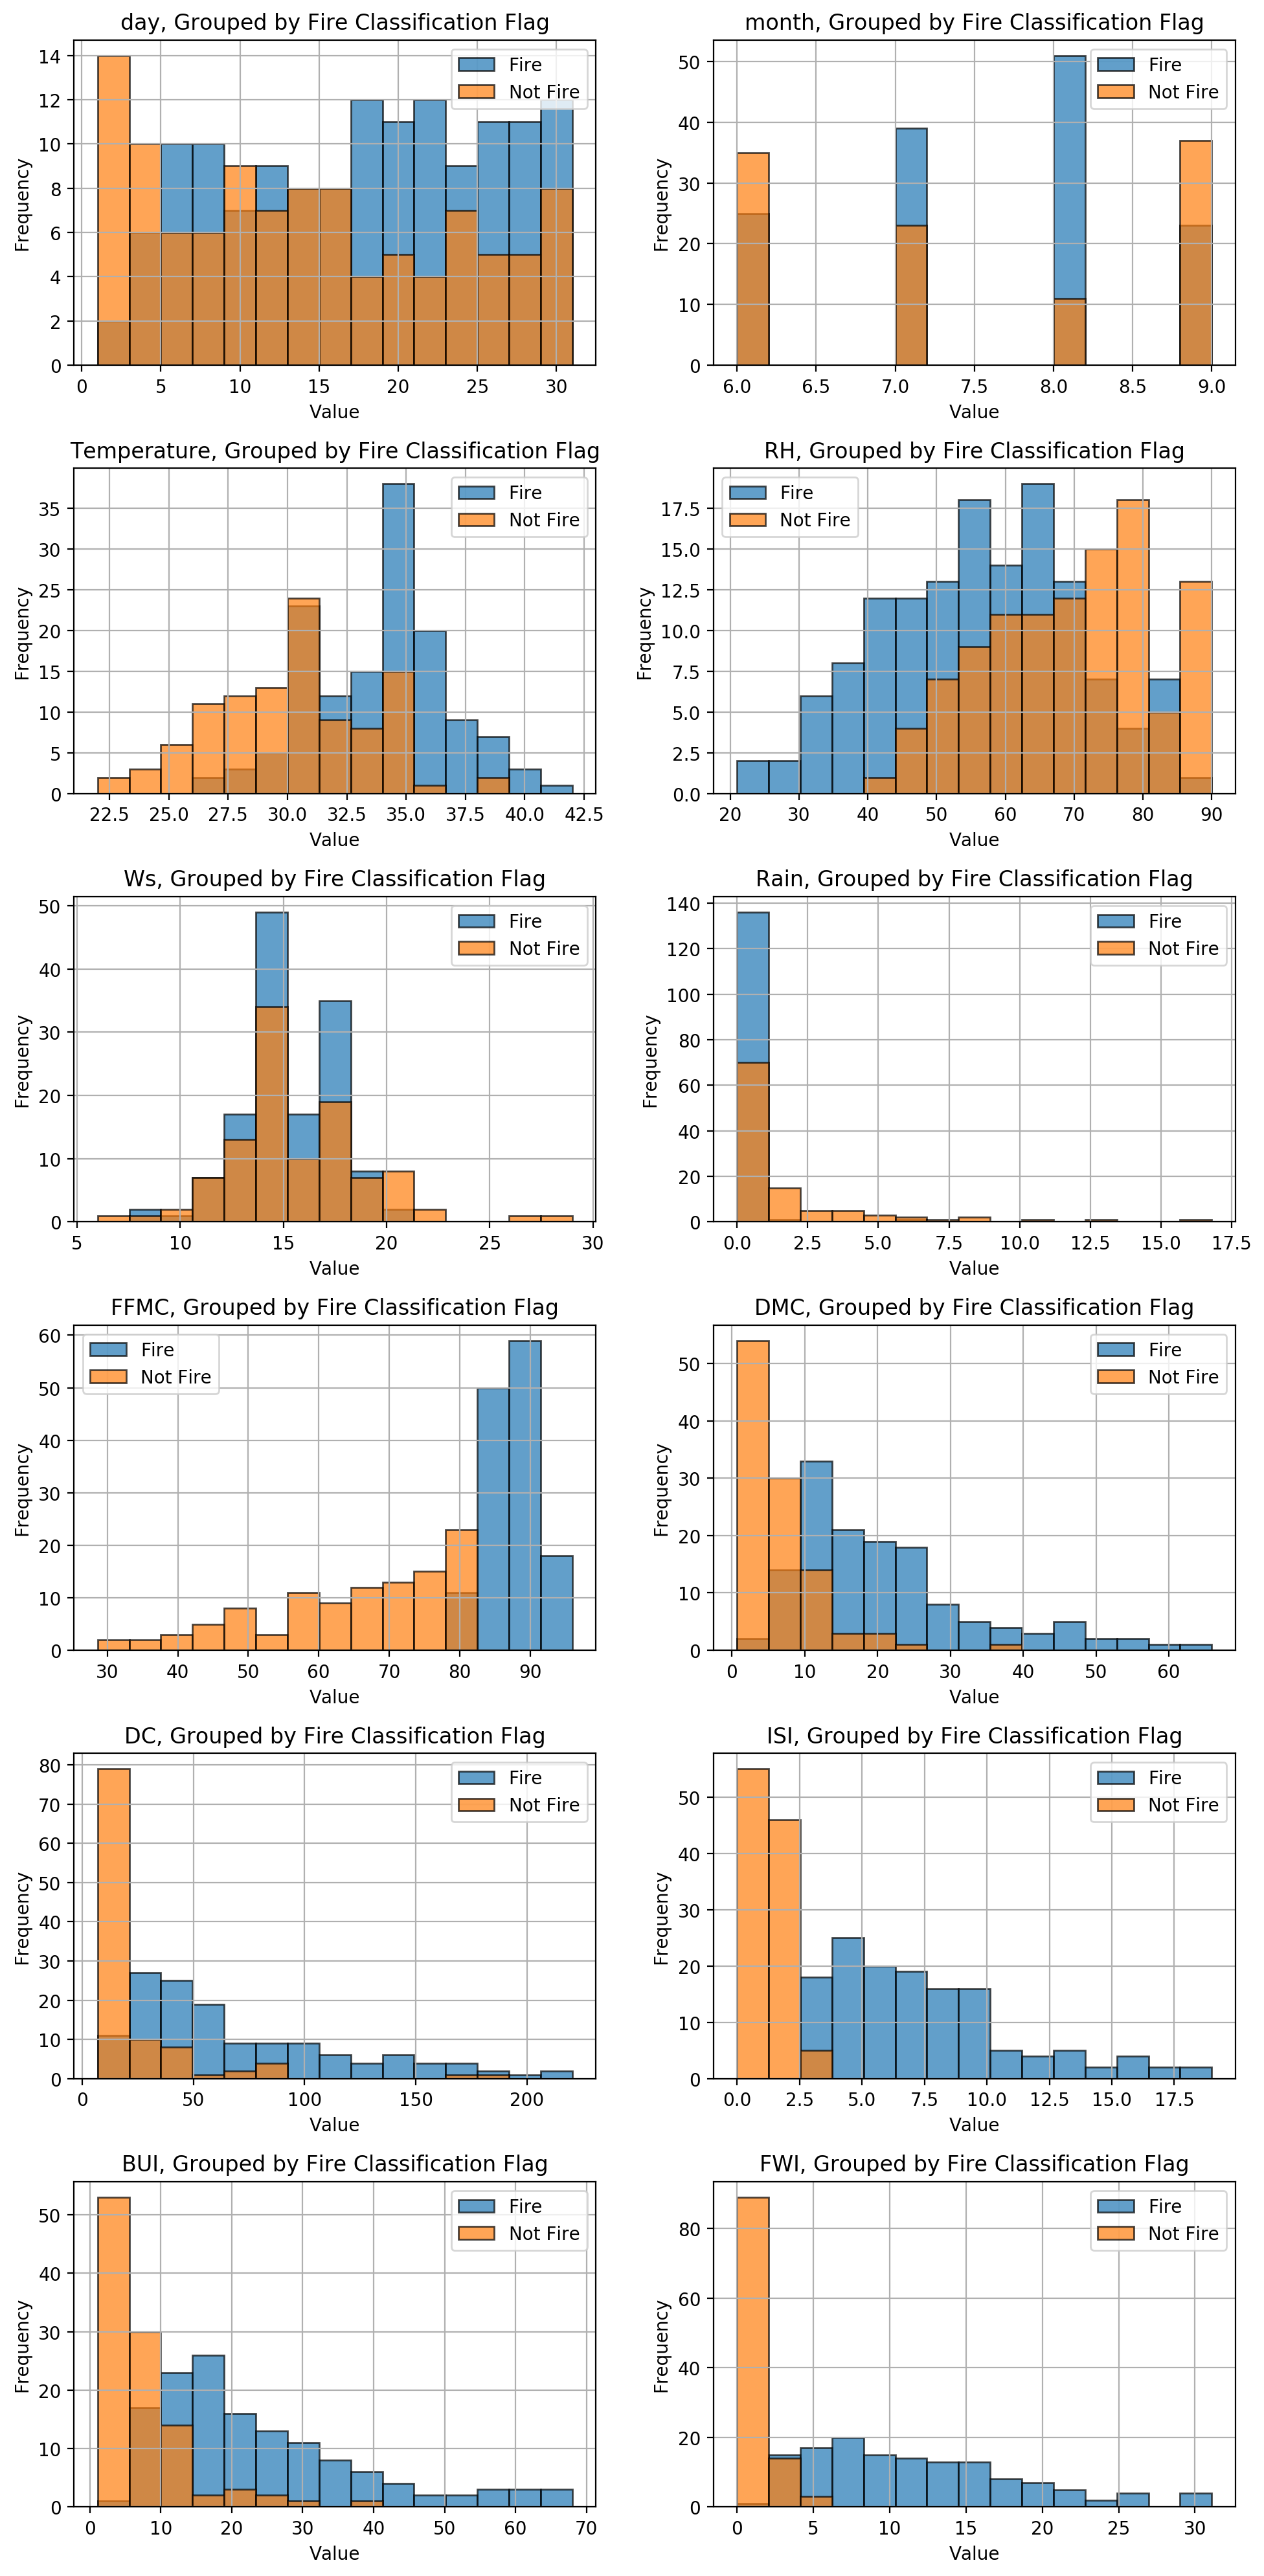

In [293]:

class_df = fire_df.groupby('Classes')
fire_true_df = class_df.get_group('fire')
fire_false_df = class_df.get_group('not fire')

cols = ['day','month','Temperature','RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI']
count=0

fig, ax = plt.subplots(6,2,figsize=(10,20),dpi=200)
for i,col in enumerate(ax):
    for j, row in enumerate(col):
        #col = 'Temperature'
        """
        print("Flagged Fires:")
        print(f"FWI Median = {np.median(fire_true_df[col])}")
        print(f"FWI Standard Deviation = {np.std(fire_true_df[col])}")

        print("Not Fires:")
        print(f"FWI Median = {np.median(fire_false_df[col])}")
        print(f"FWI Standard Deviation = {np.std(fire_false_df[col])}")
        """
        stacked = np.hstack((fire_true_df[cols[count]],fire_false_df[cols[count]]))
        bins=np.histogram(np.hstack((fire_true_df[cols[count]],fire_false_df[cols[count]])), bins=15)[1] #get the bin edges
        x = [fire_false_df[cols[count]],fire_true_df[cols[count]]]
        colors=['blue','orange']
        ax[i,j].hist(fire_true_df[cols[count]],bins,ec='k',alpha=0.7,label='Fire',stacked=True)
        ax[i,j].hist(fire_false_df[cols[count]],bins,ec='k',alpha=0.7,label='Not Fire',stacked=True)
        #ax[i,j].hist(stacked,bins,ec='k',alpha=0.7,label='Not Fire',stacked=True)

        ax[i,j].set_title(f'{cols[count]}, Grouped by Fire Classification Flag')
        ax[i,j].grid()
        ax[i,j].legend()
        ax[i,j].set_xlabel('Value')
        ax[i,j].set_ylabel('Frequency')
        count+=1
plt.tight_layout()
plt.savefig("fireclass_hists.png")

C:\Users\dougr\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\dougr\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\dougr\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


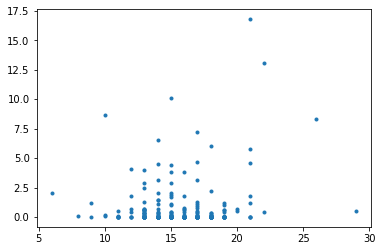

In [248]:
plt.plot(fire_df['Ws'],fire_df['Rain'],'.')

## Data Preprocessing

### Normalization

In [116]:
# Normalization
cols_to_norm = ['Temperature','RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI']

#min-max normalization
min_max_df = fire_df.copy(deep=True)
for col in min_max_df.columns:
    if col in cols_to_norm:
        arr = np.array(min_max_df[col])
        arrmin = min(arr)
        arrmax = max(arr)

        min_max_df[col] = (arr-arrmin)/(arrmax-arrmin)

#z-score normalization
zscore_df = fire_df.copy(deep=True)
for col in min_max_df.columns:
    if col in cols_to_norm:
        arr = np.array(zscore_df[col])
        arrmean = np.mean(arr)
        arrstd = np.std(arr)

        zscore_df[col] = (arr-arrmean)/(arrstd)

#decimal scaling normalization
dec_df = fire_df.copy(deep=True)
for col in min_max_df.columns:
    if col in cols_to_norm:
        arr = np.array(dec_df[col])
        arrmax = max(arr)
        dec = len(str(int(arrmax)))

        dec_df[col] = arr/(10**dec)



In [118]:
zscore_df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,-0.874735,-0.332478,0.889990,-0.381223,-0.851801,-0.913365,-0.877239,-0.834479,-0.936556,-0.883457,not fire,Bejaia
1,2,6,2012,-0.874735,-0.063185,-0.892913,0.270307,-0.942658,-0.856651,-0.877239,-0.906836,-0.901277,-0.896947,not fire,Bejaia
2,3,6,2012,-1.702005,1.350607,2.316313,6.184192,-2.151758,-0.986283,-0.887760,-1.075669,-0.985948,-0.937415,not fire,Bejaia
3,4,6,2012,-1.977761,1.821872,-0.892913,0.871719,-3.444727,-1.083506,-0.891969,-1.148026,-1.056507,-0.950905,not fire,Bejaia
4,5,6,2012,-1.426248,1.013990,0.176829,-0.381223,-0.914702,-0.945773,-0.738355,-0.858598,-0.901277,-0.883457,not fire,Bejaia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,26,9,2012,-0.598979,0.206109,-0.536333,-0.381223,0.525036,0.107484,-0.100756,-0.062670,0.015991,-0.074082,fire,Sidi-Bel Abbes
240,27,9,2012,-1.150492,1.687225,-0.179752,1.823955,-2.571100,-0.662204,-0.868821,-1.123907,-0.738991,-0.950905,not fire,Sidi-Bel Abbes
241,28,9,2012,-1.426248,1.687225,4.812379,-0.130635,-2.235627,-0.905263,-0.870926,-1.051550,-0.936556,-0.923926,not fire,Sidi-Bel Abbes
242,29,9,2012,-2.253517,-0.534449,0.889990,-0.331105,0.126662,-0.840447,-0.717313,-0.738002,-0.816606,-0.856478,not fire,Sidi-Bel Abbes


In [297]:
dec_df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,0.29,0.57,0.18,0.000,0.657,0.034,0.0076,0.013,0.034,0.005,not fire,Bejaia
1,2,6,2012,0.29,0.61,0.13,0.013,0.644,0.041,0.0076,0.010,0.039,0.004,not fire,Bejaia
2,3,6,2012,0.26,0.82,0.22,0.131,0.471,0.025,0.0071,0.003,0.027,0.001,not fire,Bejaia
3,4,6,2012,0.25,0.89,0.13,0.025,0.286,0.013,0.0069,0.000,0.017,0.000,not fire,Bejaia
4,5,6,2012,0.27,0.77,0.16,0.000,0.648,0.030,0.0142,0.012,0.039,0.005,not fire,Bejaia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,26,9,2012,0.30,0.65,0.14,0.000,0.854,0.160,0.0445,0.045,0.169,0.065,fire,Sidi-Bel Abbes
240,27,9,2012,0.28,0.87,0.15,0.044,0.411,0.065,0.0080,0.001,0.062,0.000,not fire,Sidi-Bel Abbes
241,28,9,2012,0.27,0.87,0.29,0.005,0.459,0.035,0.0079,0.004,0.034,0.002,not fire,Sidi-Bel Abbes
242,29,9,2012,0.24,0.54,0.18,0.001,0.797,0.043,0.0152,0.017,0.051,0.007,not fire,Sidi-Bel Abbes


In [300]:
min_max_df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,0.35,0.521739,0.521739,0.000000,0.550445,0.041411,0.003279,0.068421,0.034380,0.016077,not fire,Bejaia
1,2,6,2012,0.35,0.579710,0.304348,0.077381,0.531157,0.052147,0.003279,0.052632,0.041854,0.012862,not fire,Bejaia
2,3,6,2012,0.20,0.884058,0.695652,0.779762,0.274481,0.027607,0.000937,0.015789,0.023916,0.003215,not fire,Bejaia
3,4,6,2012,0.15,0.985507,0.304348,0.148810,0.000000,0.009202,0.000000,0.000000,0.008969,0.000000,not fire,Bejaia
4,5,6,2012,0.25,0.811594,0.434783,0.000000,0.537092,0.035276,0.034192,0.063158,0.041854,0.016077,not fire,Bejaia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,26,9,2012,0.40,0.637681,0.347826,0.000000,0.842730,0.234663,0.176112,0.236842,0.236173,0.209003,fire,Sidi-Bel Abbes
240,27,9,2012,0.30,0.956522,0.391304,0.261905,0.185460,0.088957,0.005152,0.005263,0.076233,0.000000,not fire,Sidi-Bel Abbes
241,28,9,2012,0.25,0.956522,1.000000,0.029762,0.256677,0.042945,0.004684,0.021053,0.034380,0.006431,not fire,Sidi-Bel Abbes
242,29,9,2012,0.10,0.478261,0.521739,0.005952,0.758160,0.055215,0.038876,0.089474,0.059791,0.022508,not fire,Sidi-Bel Abbes


### Binning

In [158]:
# equal frequency
def equifreq(arr, n):
    arr1=[]   
    count=0
    curbin=[]
    for val in arr:
        
        if count < n :
            curbin.append(val)
            count+=1
        elif count==n:
            arr1.append(curbin)
            curbin=[]
            count=0
    return arr1

 
# equal width
def equiwidth(arr1, m):
    a = len(arr1)
    w = int((max(arr1) - min(arr1)) / m)
    min1 = min(arr1)
    arr = []
    for i in range(0, m + 1):
        arr = arr + [min1 + w * i]
    arri=[]
     
    for i in range(0, m):
        temp = []
        for j in arr1:
            if j >= arr[i] and j <= arr[i+1]:
                temp += [j]
        arri += [temp]
    return arri

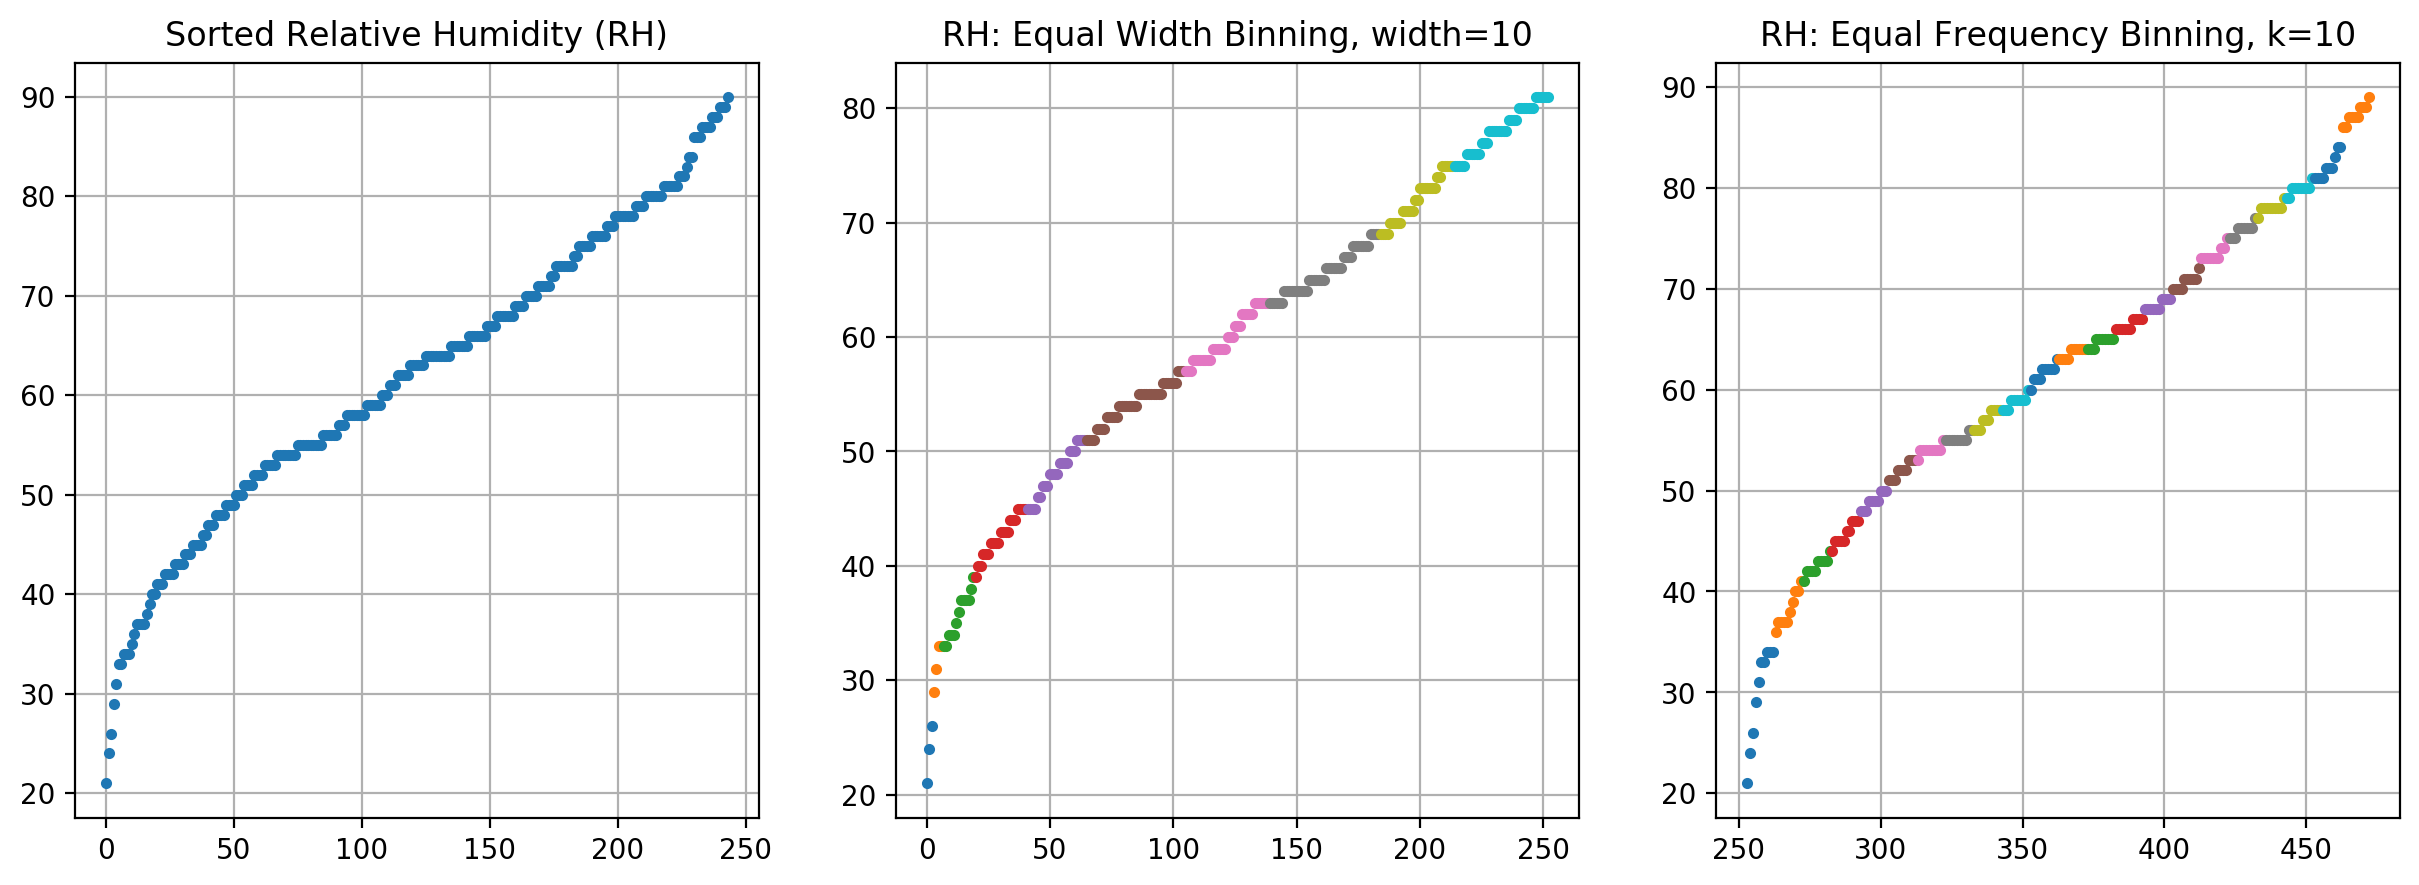

In [302]:
#Part 2: Binning

#Equal Width Binning

fig, ax = plt.subplots(1,3,figsize=(15,5),dpi=200)

ax[0].plot(np.sort(fire_df['RH']),'.')
ax[0].set_title("Sorted Relative Humidity (RH)")
ax[0].grid()

ax[1].set_title("RH: Equal Width Binning, width=10")
eqwidth = equiwidth(np.sort(fire_df['RH']),10)
count=0
for eqbin in eqwidth:
    idx = np.arange(count,count+len(eqbin),1)
    count+=len(eqbin)
    ax[1].plot(idx, eqbin,'.')
ax[1].grid()
ax[2].set_title("RH: Equal Frequency Binning, k=10")
eqfreq = equifreq(np.sort(fire_df['RH']),10)
for eqbin in eqfreq:
    idx = np.arange(count,count+len(eqbin),1)
    count+=len(eqbin)
    ax[2].plot(idx, eqbin,'.')
ax[2].grid()
plt.savefig('binning_rh.png')

### Normality Transformation

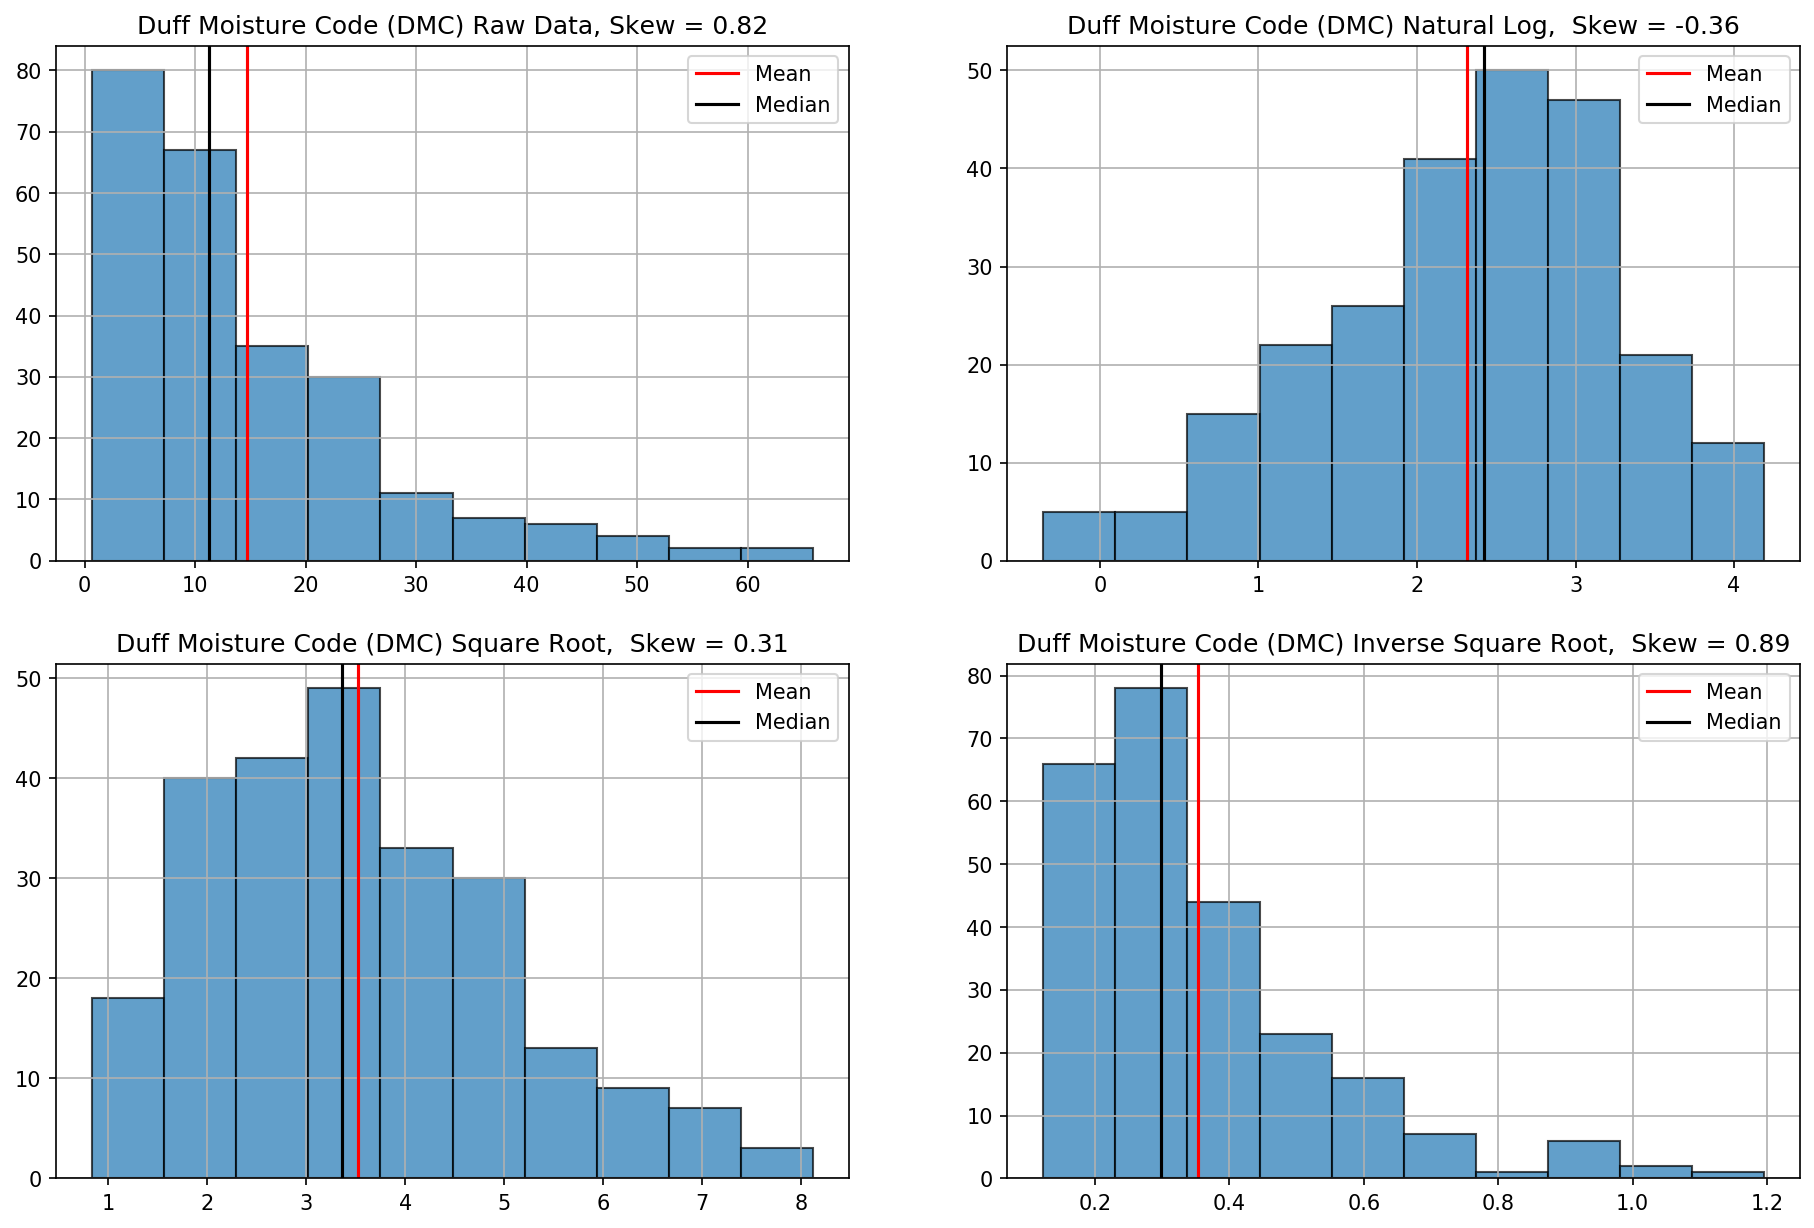

In [313]:
# Drought Code appears to not follow a normal distribution
fig, ax = plt.subplots(2,2,figsize=(15,10),dpi=150)

dc_arr = np.array(fire_df['DMC'])

#Raw Data
skew = 3*((np.mean(dc_arr)-np.median(dc_arr))/np.std(dc_arr))
ax[0,0].hist(dc_arr,ec='k',alpha=0.7)
ax[0,0].axvline(np.mean(dc_arr),label='Mean',color='r')
ax[0,0].axvline(np.median(dc_arr),label='Median',color='k')
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_title(f'Duff Moisture Code (DMC) Raw Data, Skew = {np.round(skew,2)}')

#Natural Log Transformation
dc_ln = np.log(dc_arr)
skew = 3*((np.mean(dc_ln)-np.median(dc_ln))/np.std(dc_ln))
ax[0,1].hist(dc_ln,ec='k',alpha=0.7)
ax[0,1].axvline(np.mean(dc_ln),label='Mean',color='r')
ax[0,1].axvline(np.median(dc_ln),label='Median',color='k')
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].set_title(f'Duff Moisture Code (DMC) Natural Log,  Skew = {np.round(skew,2)}')

#Square Root Transformation
dc_sqrt = np.sqrt(dc_arr)
skew = 3*((np.mean(dc_sqrt)-np.median(dc_sqrt))/np.std(dc_sqrt))
ax[1,0].hist(dc_sqrt,ec='k',alpha=0.7)
ax[1,0].axvline(np.mean(dc_sqrt),label='Mean',color='r')
ax[1,0].axvline(np.median(dc_sqrt),label='Median',color='k')
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].set_title(f'Duff Moisture Code (DMC) Square Root,  Skew = {np.round(skew,2)}')

#Inverse Square Root Transformation
dc_invsqrt = 1/np.sqrt(dc_arr)
skew = 3*((np.mean(dc_invsqrt)-np.median(dc_invsqrt))/np.std(dc_invsqrt))
ax[1,1].hist(dc_invsqrt,ec='k',alpha=0.7)
ax[1,1].axvline(np.mean(dc_invsqrt),label='Mean',color='r')
ax[1,1].axvline(np.median(dc_invsqrt),label='Median',color='k')
ax[1,1].legend()
ax[1,1].grid()
ax[1,1].set_title(f'Duff Moisture Code (DMC) Inverse Square Root,  Skew = {np.round(skew,2)}')

plt.savefig('normalization_dmc.png')

## Regression Analysis

The question to answer: Can we predict the ISI (Initial Spread Index) component of the Fire Weather Index based on the non-FWI information?

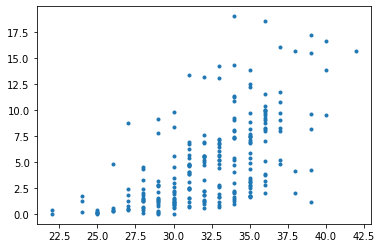

In [237]:
plt.plot(fire_df['Temperature'],fire_df['ISI'],'.')

Text(0.5, 0, 'Fire Weather Index')

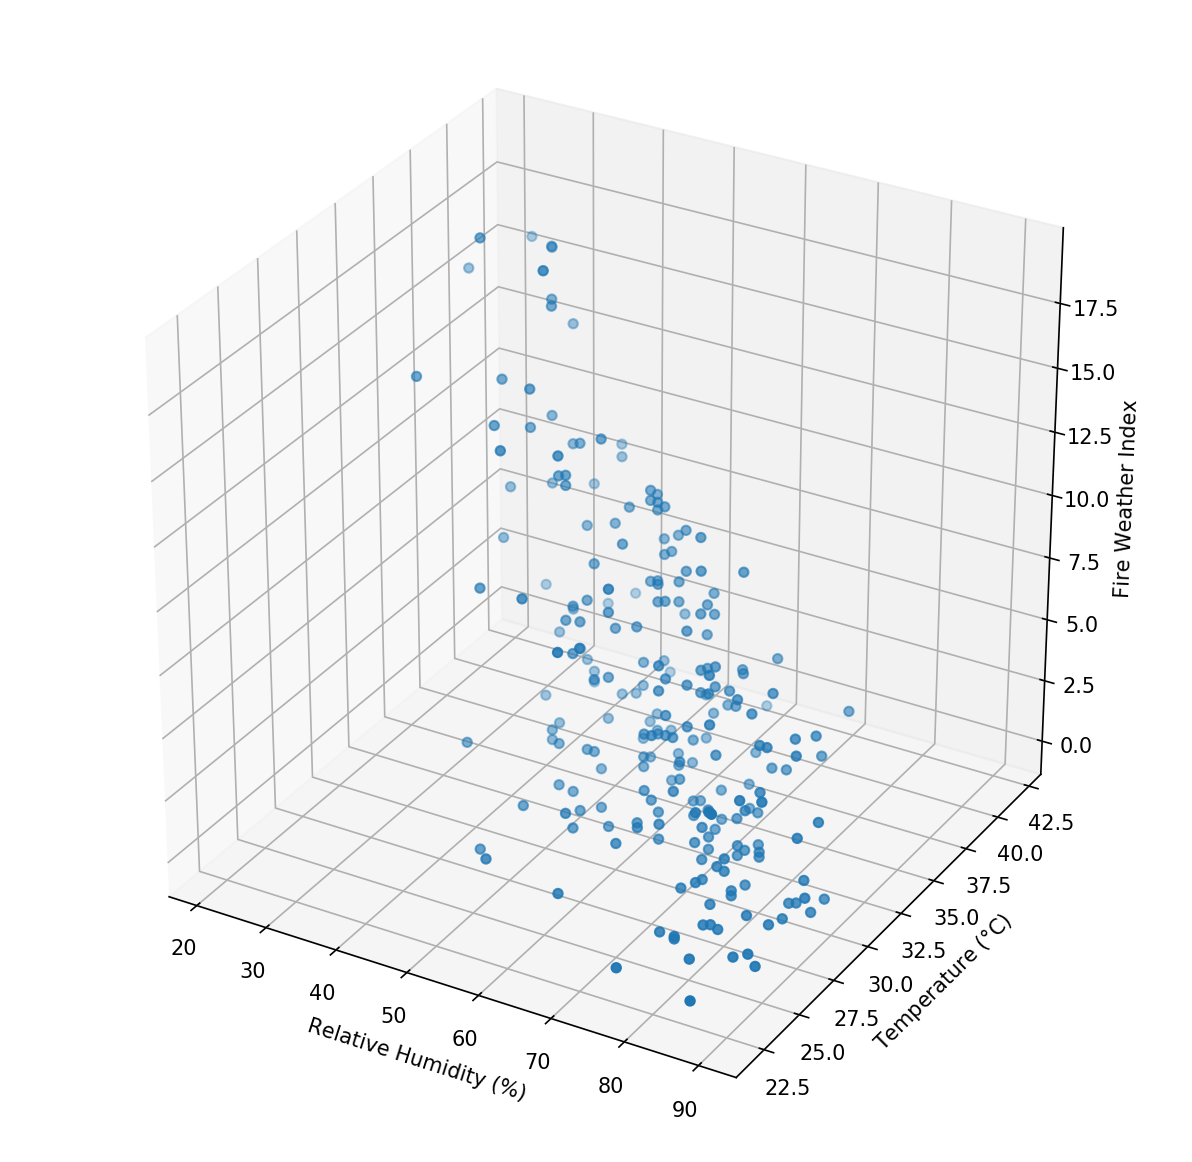

In [235]:
fig =plt.figure(figsize=(10,10),dpi=150)
ax = plt.axes(projection='3d')
ax.scatter3D(fire_df['RH'],fire_df['Temperature'],fire_df['ISI'])
ax.set_ylabel(r"Temperature ($\degree$C)")
ax.set_xlabel("Relative Humidity (%)")
ax.set_zlabel("Fire Weather Index")

In [275]:
target = 'ISI'
X = fire_df[['RH','Temperature','Rain','Ws']]
y = fire_df[target]

regr = linear_model.LinearRegression()
regr.fit(X,y)
print(regr.coef_)

rh_x = np.linspace(90,20,50)
temp_x = np.linspace(22.5,45,50)
rain_x = np.linspace(0,15,50)
ws_x = np.linspace(0,25,50)
predicted_fwi = regr.predict(list(zip(rh_x,temp_x,rain_x,ws_x)))
predicted_fwi_direct = regr.predict(X)
rsquared = metrics.r2_score(fire_df[target],predicted_fwi_direct)
print(rsquared)




[-0.14800912  0.30456799 -0.38213057  0.35898225]
0.5933246947032235


C:\Users\dougr\Miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


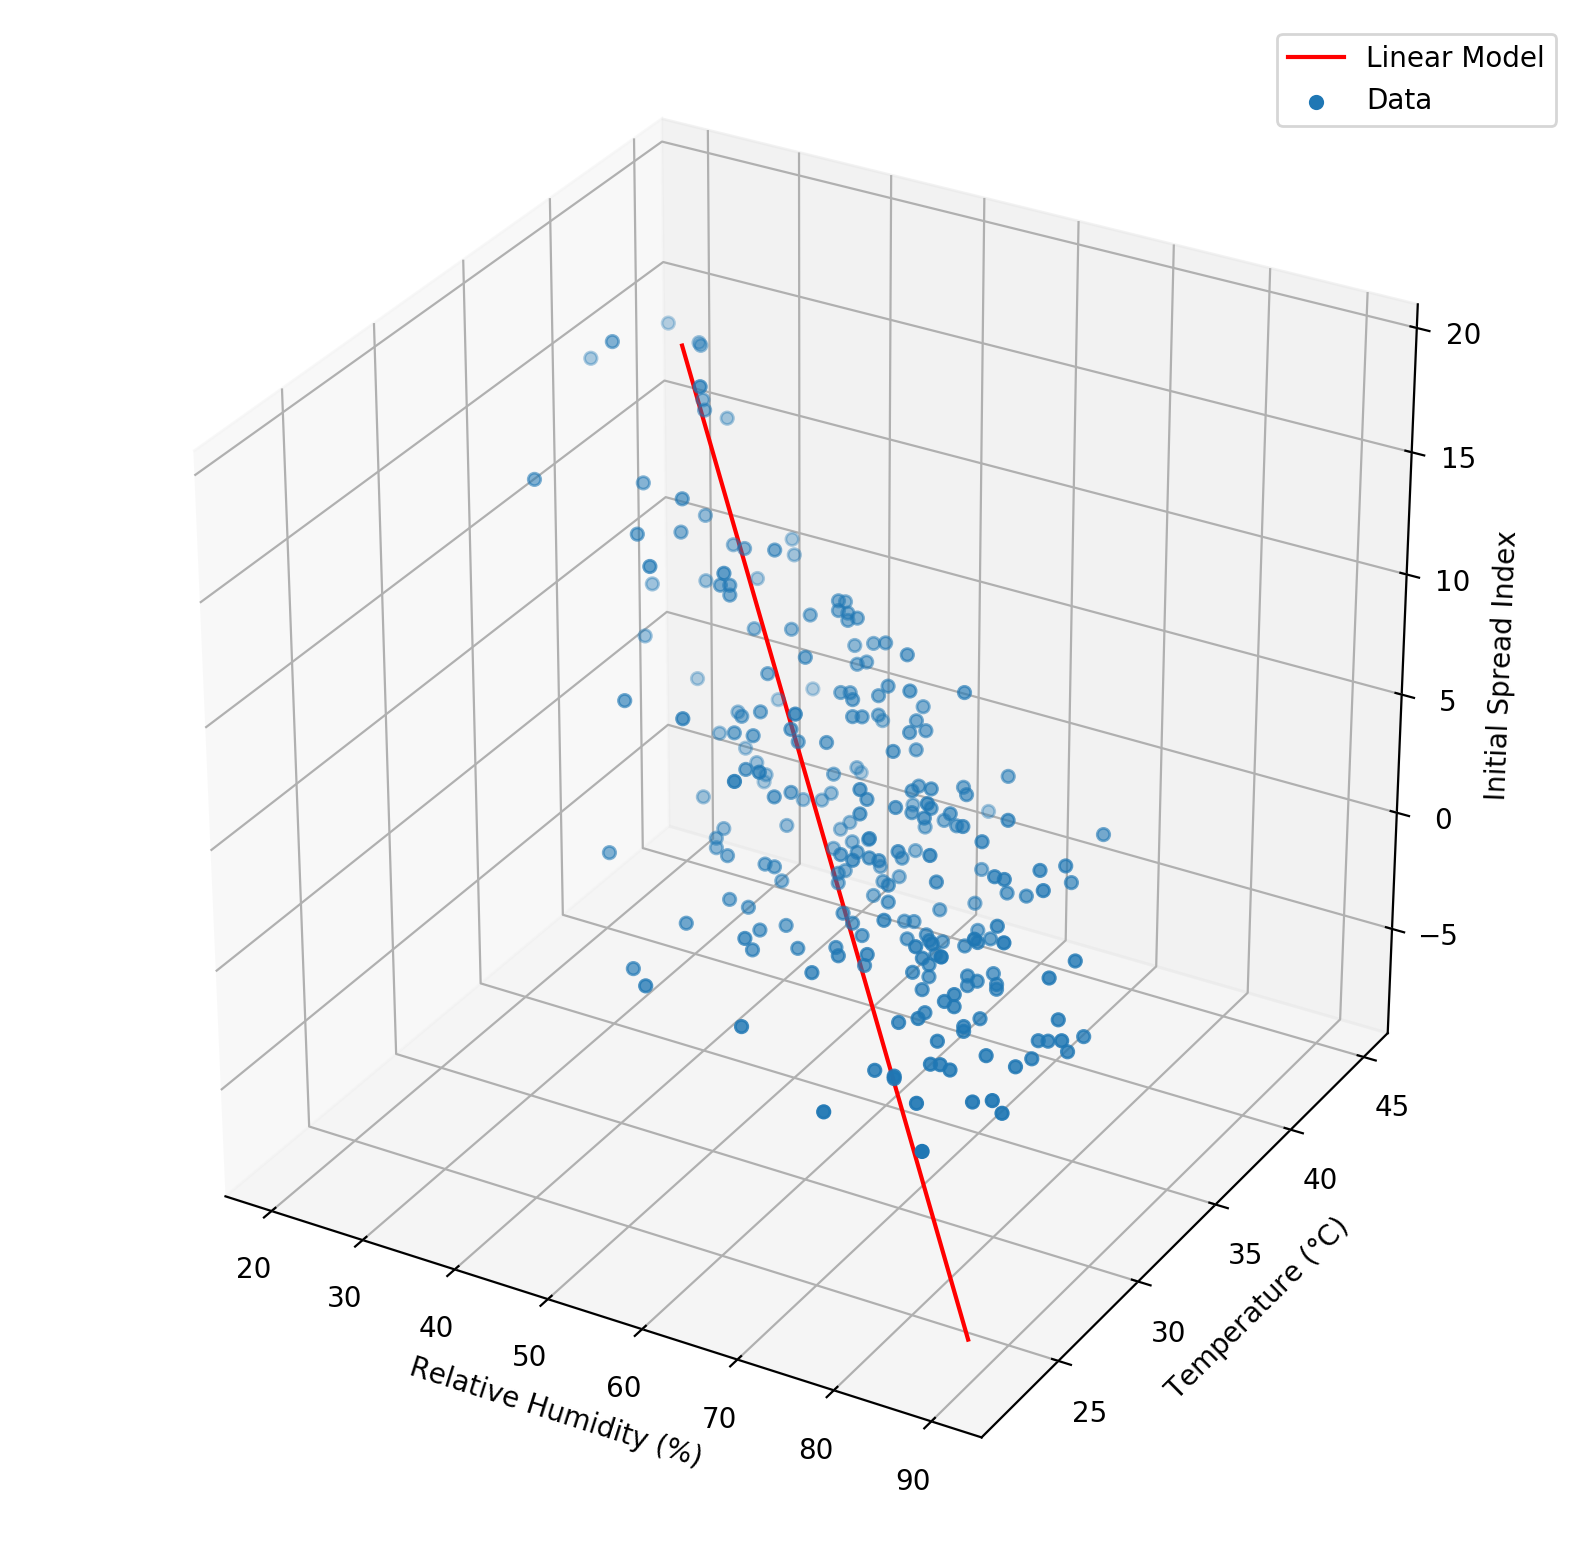

In [304]:
fig =plt.figure(figsize=(10,10),dpi=200)
ax = plt.axes(projection='3d')
ax.scatter3D(fire_df['RH'],fire_df['Temperature'],fire_df[target],label='Data')
ax.plot3D(rh_x,temp_x,predicted_fwi,'-',color='r',label='Linear Model')
ax.set_ylabel(r"Temperature ($\degree$C)")
ax.set_xlabel("Relative Humidity (%)")
ax.set_zlabel("Initial Spread Index")
ax.legend()

plt.savefig('linfit_fwi.png')

C:\Users\dougr\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\dougr\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\dougr\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


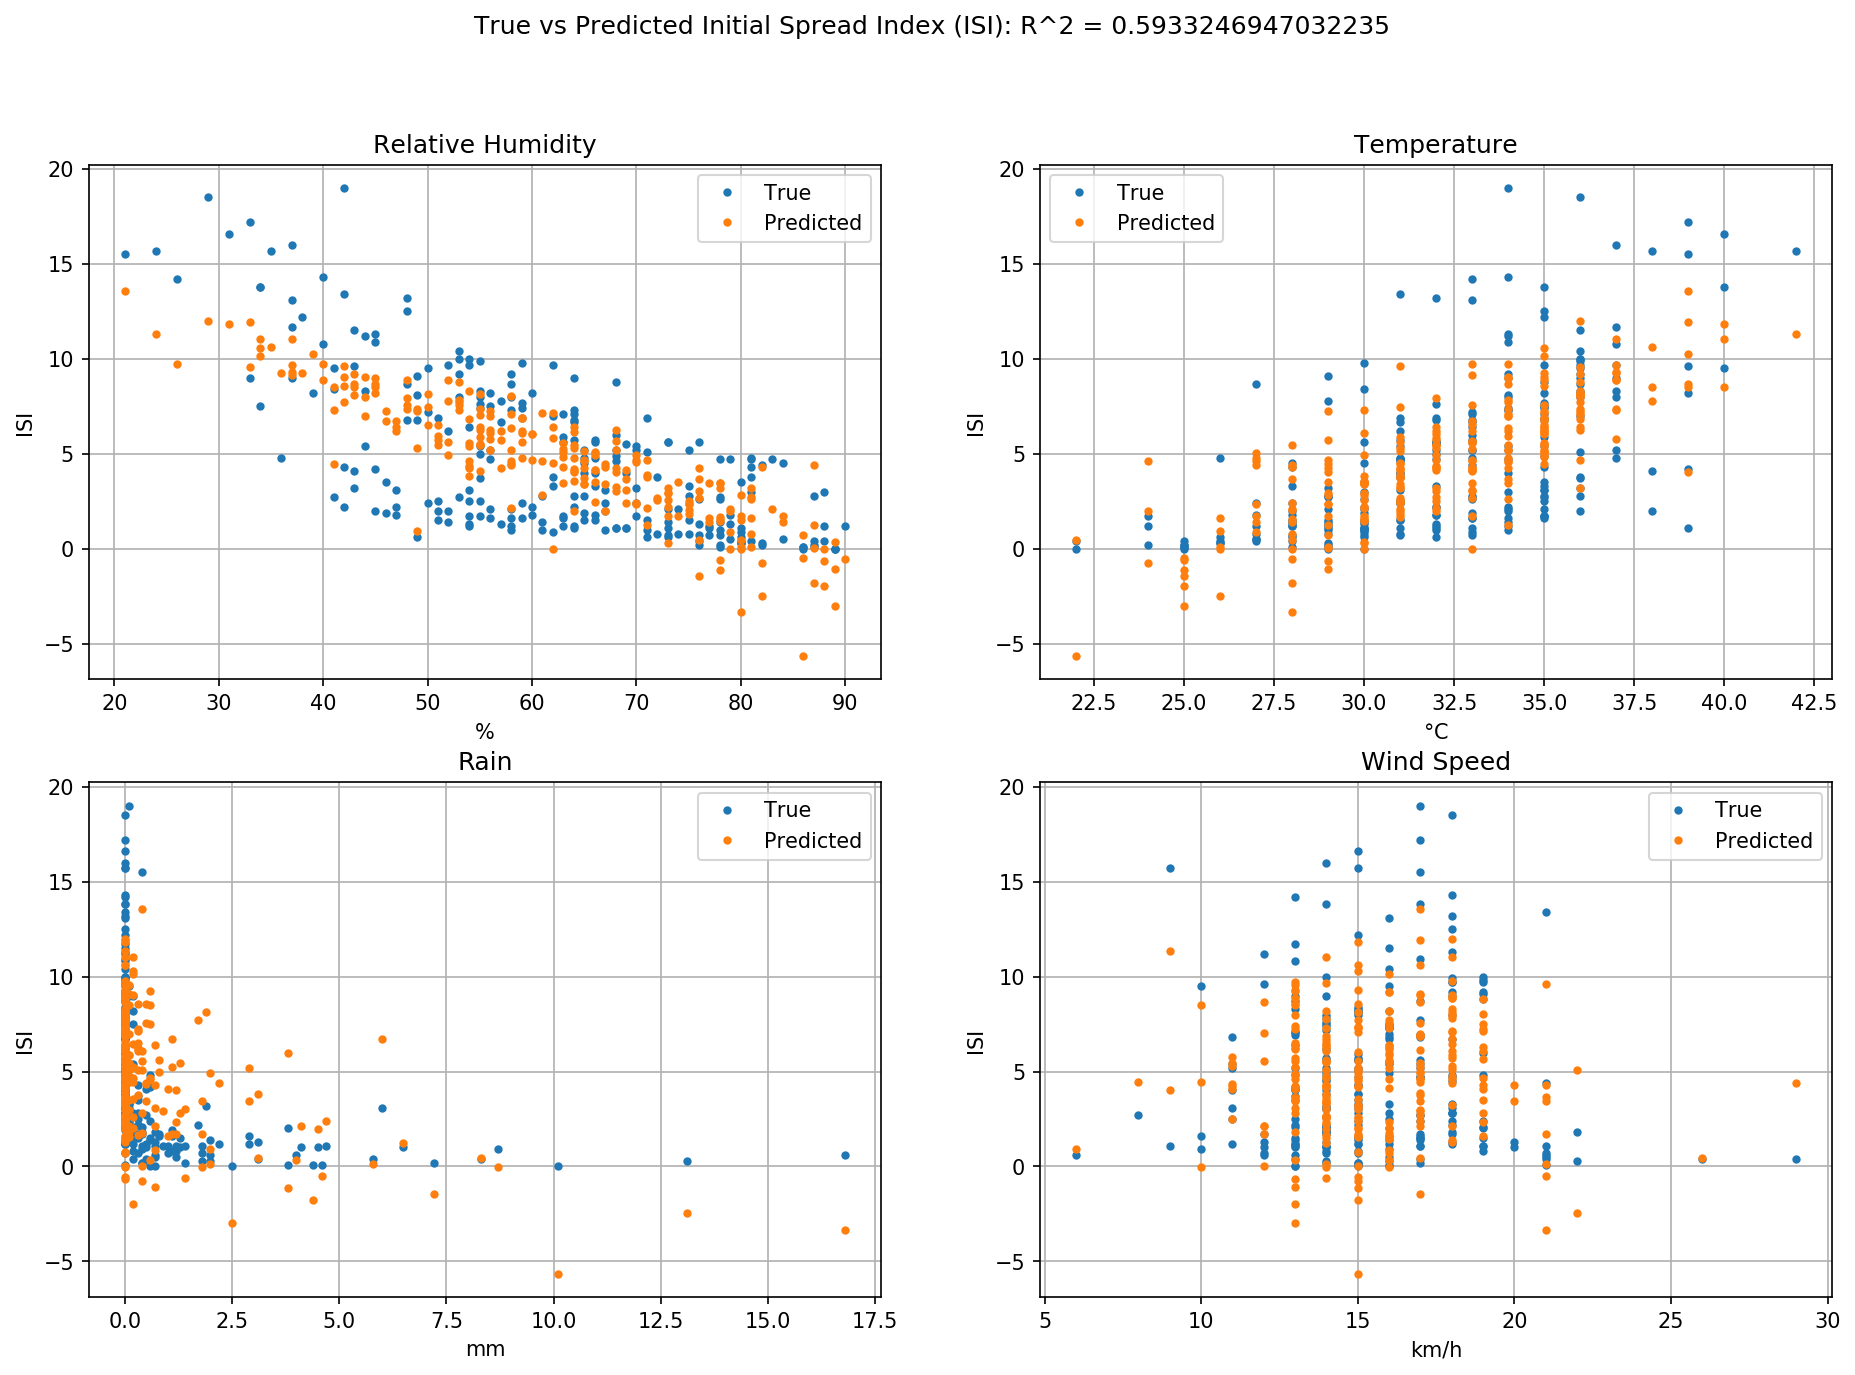

In [305]:
fig, ax = plt.subplots(2,2, figsize=(15,10),dpi=150)
fig.suptitle(f"True vs Predicted Initial Spread Index (ISI): R^2 = {rsquared}")

ax[0,0].plot(fire_df['RH'],fire_df[target],'.',label='True')
ax[0,0].plot(fire_df['RH'],predicted_fwi_direct,'.',label='Predicted')
ax[0,0].set_title('Relative Humidity')
ax[0,0].set_xlabel('%')
ax[0,0].set_ylabel('ISI')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(fire_df['Temperature'],fire_df[target],'.',label='True')
ax[0,1].plot(fire_df['Temperature'],predicted_fwi_direct,'.',label='Predicted')
ax[0,1].set_title('Temperature')
ax[0,1].set_xlabel('$\degree$C')
ax[0,1].set_ylabel('ISI')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(fire_df['Rain'],fire_df[target],'.',label='True')
ax[1,0].plot(fire_df['Rain'],predicted_fwi_direct,'.',label='Predicted')
ax[1,0].set_title('Rain')
ax[1,0].set_xlabel('mm')
ax[1,0].set_ylabel('ISI')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].plot(fire_df['Ws'],fire_df[target],'.',label='True')
ax[1,1].plot(fire_df['Ws'],predicted_fwi_direct,'.',label='Predicted')
ax[1,1].set_title('Wind Speed')
ax[1,1].set_xlabel('km/h')
ax[1,1].set_ylabel('ISI')
ax[1,1].grid()
ax[1,1].legend()

plt.savefig('true_vs_predicted.png')